model loaded successfully : mobile_net_model
Trying to open : -f
running deeplab on image image_4.jpg...
Time taken to evaluate segmentation is : 0:00:00.318383


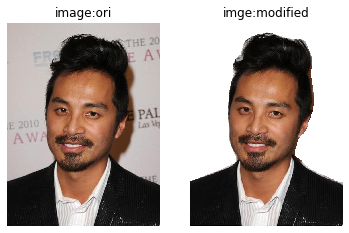

In [9]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from io import BytesIO

import numpy as np
from PIL import Image

import tensorflow as tf
import tensorflow.compat.v1 as tf # sace: to fix the error :"module 'tensorflow' has no attribute 'GraphDef'"

import sys
import datetime

# input num of the image:
num = 4

class DeepLabModel(object):
  """Class to load deeplab model and run inference."""

  INPUT_TENSOR_NAME = 'ImageTensor:0'
  OUTPUT_TENSOR_NAME = 'SemanticPredictions:0'
  INPUT_SIZE = 513
  FROZEN_GRAPH_NAME = 'frozen_inference_graph'

  def __init__(self, tarball_path):
    """Creates and loads pretrained deeplab model."""
    self.graph = tf.Graph()

    graph_def = None
    graph_def = tf.GraphDef.FromString(open(tarball_path + "/frozen_inference_graph.pb", "rb").read()) 

    if graph_def is None:
      raise RuntimeError('Cannot find inference graph in tar archive.')

    with self.graph.as_default():
      tf.import_graph_def(graph_def, name='')

    self.sess = tf.Session(graph=self.graph)

  def run(self, image):
    """Runs inference on a single image.

    Args:
      image: A PIL.Image object, raw input image.

    Returns:
      resized_image: RGB image resized from original input image.
      seg_map: Segmentation map of `resized_image`.
    """
    start = datetime.datetime.now()

    width, height = image.size
    resize_ratio = 1.0 * self.INPUT_SIZE / max(width, height)
    target_size = (int(resize_ratio * width), int(resize_ratio * height))
    resized_image = image.convert('RGB').resize(target_size, Image.ANTIALIAS)
    batch_seg_map = self.sess.run(
        self.OUTPUT_TENSOR_NAME,
        feed_dict={self.INPUT_TENSOR_NAME: [np.asarray(resized_image)]})
    seg_map = batch_seg_map[0]

    end = datetime.datetime.now()

    diff = end - start
    print("Time taken to evaluate segmentation is : " + str(diff))

    return resized_image, seg_map

def drawSegment(baseImg, matImg):
  width, height = baseImg.size
  dummyImg = np.zeros([height, width, 4], dtype=np.uint8)
  for x in range(width):
            for y in range(height):
                color = matImg[y,x]
                (r,g,b) = baseImg.getpixel((x,y))
                if color == 0:
                    dummyImg[y,x,3] = 0
                else :
                    dummyImg[y,x] = [r,g,b,255]
  img = Image.fromarray(dummyImg)
  img.save(outputFilePath)

# inputFilePath = sys.argv[1]
# outputFilePath = sys.argv[2]

inputFilePath =  'image_{}.jpg'.format(num)
outputFilePath = 'output_{}.png'.format(num)

if inputFilePath is None or outputFilePath is None:
  print("Bad parameters. Please specify input file path and output file path")
  exit()

modelType = "mobile_net_model"
# if len(sys.argv) > 3 and sys.argv[3] == "1":
#   modelType = "xception_model"
argv_3 = 1

if argv_3 == "1":
  modelType = "xception_model"

MODEL = DeepLabModel(modelType)
print('model loaded successfully : ' + modelType)

def run_visualization(filepath):
  """Inferences DeepLab model and visualizes result."""
  try:
  	print("Trying to open : " + sys.argv[1])
  	# f = open(sys.argv[1])
  	jpeg_str = open(filepath, "rb").read()
  	orignal_im = Image.open(BytesIO(jpeg_str))
  except IOError:
    print('Cannot retrieve image. Please check file: ' + filepath)
    return

  print('running deeplab on image %s...' % filepath)
  resized_im, seg_map = MODEL.run(orignal_im)

  # vis_segmentation(resized_im, seg_map)
  drawSegment(resized_im, seg_map)

run_visualization(inputFilePath)

# from PIL import Image
# from IPython.display import Image as IMG

# display(IMG('image_{}.jpg'.format(num)))
# display(IMG('output_{}.png'.format(num)))
import matplotlib.pyplot as plt 
from PIL import Image

img_in = Image.open('image_{}.jpg'.format(num), 'r')
img_out = Image.open('output_{}.png'.format(num), 'r')

plt.subplot(1,2,1), plt.title('image:ori')
plt.imshow(img_in), plt.axis('off')

plt.subplot(1,2,2), plt.title('imge:modified')
plt.imshow(img_out), plt.axis('off')

plt.show()